## Predict Ethereum price using traditional machine learning models

##### To use traditional machine learning models to predict Ether price, I reframed the multivariate time-series data into a supervised learning problem using the sliding window method, then trained data on different machine learning models.

In [1]:
# Import neccessary packages
import numpy as np 
import pandas as pd 
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
import xgboost as xgb
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
#pip install xgboost

##### Create some functions we are going to use:

In [3]:
def time_series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
def regression_metrics(y_test, y_pred):
    
    """
    Define evaluation metrics for regression problem
    y_test: true values
    y_pred: predicted values
    """
    
    print('R2 Score: ', r2_score(y_test, y_pred))
    print('Mean Absolute Error: ', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))
    MDAPE = np.mean((np.abs(np.subtract(y_test, y_pred)/ y_test)) ) * 100
    print(f'Mean Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

In [5]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    
    """ Visualize line 1 and line 2 """
        
    line1.reset_index(drop=True, inplace=True) #reset index in order to align with prediction
    line2_ser = pd.Series(line2) # convert to series so we can plot it
    plt.figure(figsize = (14,7))
    line1.plot(label='Real')
    line2_ser.plot(label='Predicted')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('Price (USD)',fontsize=15)
    plt.title(title, fontsize=20)
    plt.legend(["Real Ether Price", "Predicted Ether Price"], loc="upper left")
    plt.grid()
    plt.show()

### 1. Data loading

In [6]:
df = pd.read_csv('data/eth_clean.csv')
df.drop(columns='Unnamed: 0', inplace = True)
df

,date,PriceUSD,AdrActCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1MCnt,CapMrktCurUSD,DiffLast,...,FlowInExUSD,FlowOutExUSD,GasUsedTx,GasUsedTxMean,HashRate,RevHashNtv,RevHashRateUSD,SplyAdrBalUSD1M,TxCnt,TxTfrValMedUSD
0,2015-08-08,1.199990,1208,9958,10267,9550,10115,8111,8.676871e+07,1606016380751,...,1.033888e+06,1.698517e+04,376006093,130512.354391,0.096483,3.360253,348388.084065,1.661840e+07,2881,1.199990
1,2015-08-09,1.199990,1113,10043,10411,9573,10222,8091,8.680133e+07,1741399466631,...,6.414313e+05,1.127113e+05,38863003,29242.289691,0.101360,3.105048,321928.661618,1.682678e+07,1329,15.599147
2,2015-08-10,1.199990,1430,10145,10572,9611,10348,8101,8.683471e+07,1948102094734,...,1.055335e+06,2.135630e+05,74070061,36362.327442,0.111855,2.881582,298759.890307,1.720648e+07,2037,0.718002
3,2015-08-11,0.990000,2697,10188,10706,9614,10429,8081,7.166698e+07,2171897473895,...,4.513437e+05,1.752126e+05,163481740,32940.104775,0.124450,2.607691,223051.462249,1.551874e+07,4963,0.053993
4,2015-08-12,1.288000,1219,10296,10893,9654,10574,8105,9.327472e+07,2248237602936,...,4.743256e+05,1.891297e+05,70102332,34431.400786,0.130915,2.422720,269607.996077,1.851254e+07,2036,12.880000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,2021-11-15,4569.407770,606036,1166692,18202185,241239,5573039,36595,5.367033e+11,11263394429417836,...,8.676790e+08,1.029855e+10,97422476367,75542.615410,817.739849,0.000213,84078.925802,1.025092e+08,1289636,456.940777
2292,2021-11-16,4234.131465,609879,1165639,18237665,240967,5580973,36564,4.973249e+11,10918227329653401,...,1.755198e+09,1.678261e+09,96356492010,73545.984332,793.794054,0.000219,80290.211052,1.022489e+08,1310153,423.413146
2293,2021-11-17,4265.599006,695412,1167736,18217312,241192,5589438,36563,5.010266e+11,11549986846583558,...,1.167281e+09,1.282525e+09,98477697827,72772.919850,830.259240,0.000207,76139.406528,1.022624e+08,1353219,319.823949
2294,2021-11-18,3985.674373,591159,1170963,18239379,241438,5599347,36605,4.681491e+11,11579207148357743,...,1.555602e+09,1.424465e+09,98258045079,76510.060408,851.155962,0.000203,69860.008277,1.019504e+08,1284250,398.991334


##### In order to use machine learning models, we need to reframe our multivariate time-series data into a supervised learning problem.

### 2. Data processing

In [7]:
def data_processing(df, window_length):
   
    """
    Create a function to process data with dataframe, window length arguments:
       - Drop the column date as we don't use it as a predictor
       - Use the defined function above to convert multivariate time-series data into supervised learning
       - Remove columns (t) we don't need    
    Return: X, y
    """
    
    data = df.copy()
    data.drop(columns = 'date', axis=1, inplace=True)

    X = time_series_to_supervised(data, window_length,1)
    y = data['PriceUSD'][window_length:]

    X.drop(columns = ['var1(t)','var2(t)','var3(t)','var4(t)','var5(t)','var6(t)','var7(t)','var8(t)','var9(t)','var10(t)','var11(t)','var12(t)','var13(t)','var14(t)','var15(t)','var16(t)','var17(t)','var18(t)','var19(t)','var20(t)','var21(t)','var22(t)'], inplace=True)
    X.head()
    
    return X, y

##### Data processing

In [8]:
window_length = 7
X, y = data_processing(df, window_length)

##### Split data into train and test datasets with time-series order (shuffle=False)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### 3. Train data with different machine learning models

In [10]:
def ml_model(X_train, y_train, X_test, y_test, model, plot_title):
    
    """
    Define a pipeline, fit the model, predict price, print evaluation metrics and visualize actual and predicted price
    """
    
    # Define a pipeline
    pipeline_rf = Pipeline(steps=[('scaling', StandardScaler()), ('classifier', model)])
    
    # Fit the model
    pipeline_rf.fit(X_train, y_train)
    y_pred_rf = pipeline_rf.predict(X_test)
    
    # Print evaluation metrics
    print('Evaluation metrics: ')
    regression_metrics(y_test, y_pred_rf)
    
    # Visualize actual and predicted price
    print('')
    line_plot(y_test, y_pred_rf, title = plot_title)
    
    return pipeline_rf

#### 3.1 Random Forest Regressor

Evaluation metrics: 
R2 Score:  -0.2848908737161384
Mean Absolute Error:  1016.6228711615711
Mean Squared Error:  2063068.8086238026
Mean Absolute Percentage Error (MDAPE): 35.66 %



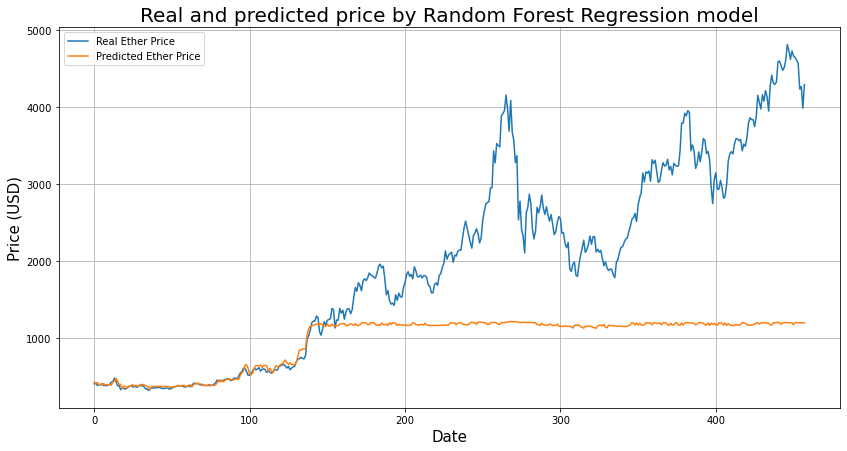

In [11]:
model = ml_model(X_train, y_train, X_test, y_test, RandomForestRegressor(), 'Real and predicted price by Random Forest Regression model')

#### 3.2 Linear Regression

Evaluation metrics: 
R2 Score:  0.9689637542208106
Mean Absolute Error:  157.70771275925395
Mean Squared Error:  49832.95617832629
Mean Absolute Percentage Error (MDAPE): 8.24 %



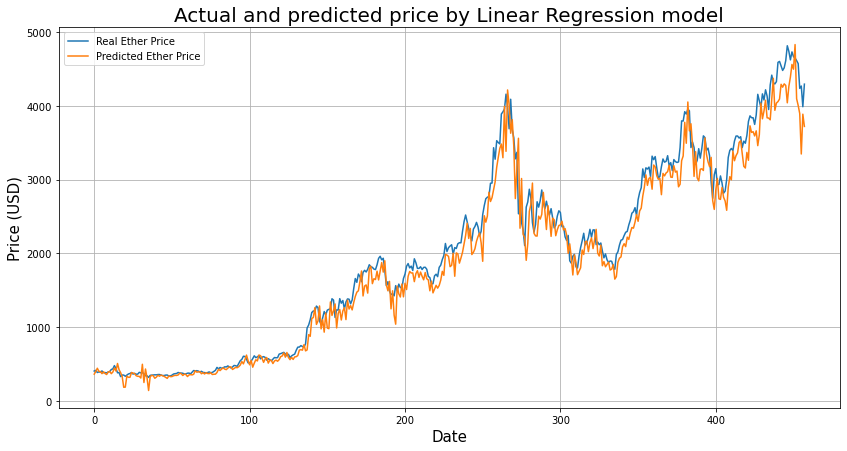

In [12]:
linear_model = ml_model(X_train, y_train, X_test, y_test, LinearRegression(), 'Actual and predicted price by Linear Regression model')

In [13]:
# Save the model to disk
filename = 'models/linear_model.sav'
pickle.dump(linear_model, open(filename, 'wb'))

#### 3.3 XGBoost

Evaluation metrics: 
R2 Score:  -0.40386418527973467
Mean Absolute Error:  1085.4280889873123
Mean Squared Error:  2254096.804204198
Mean Absolute Percentage Error (MDAPE): 38.92 %



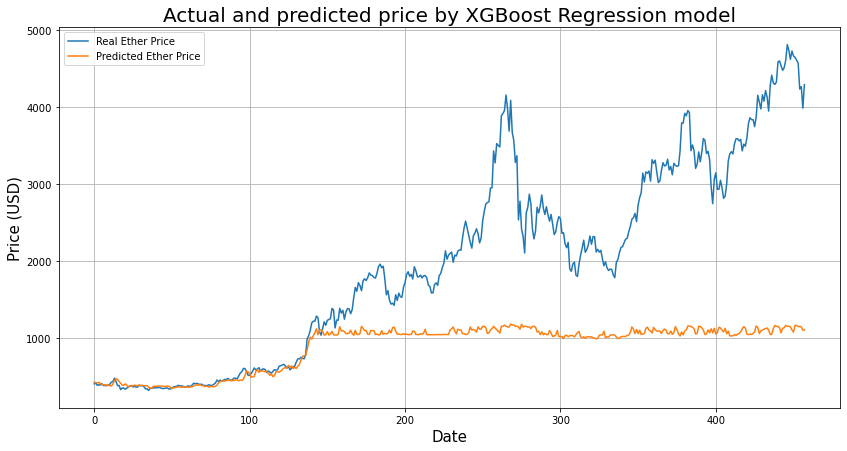

Pipeline(steps=[('scaling', StandardScaler()),
                ('classifier',
                 XGBRegressor(alpha=10, base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.3, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=10,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=150,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=13, reg_alpha=10, reg_lambda=1,
                              scale_pos_weight=1, seed=13, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [14]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 150, seed=13)

ml_model(X_train, y_train, X_test, y_test, xg_reg, 'Actual and predicted price by XGBoost Regression model')

#### 3.4 SVR

Evaluation metrics: 
R2 Score:  -1.9998832027939621
Mean Absolute Error:  1783.246981397292
Mean Squared Error:  4816724.588679723
Mean Absolute Percentage Error (MDAPE): 80.0 %



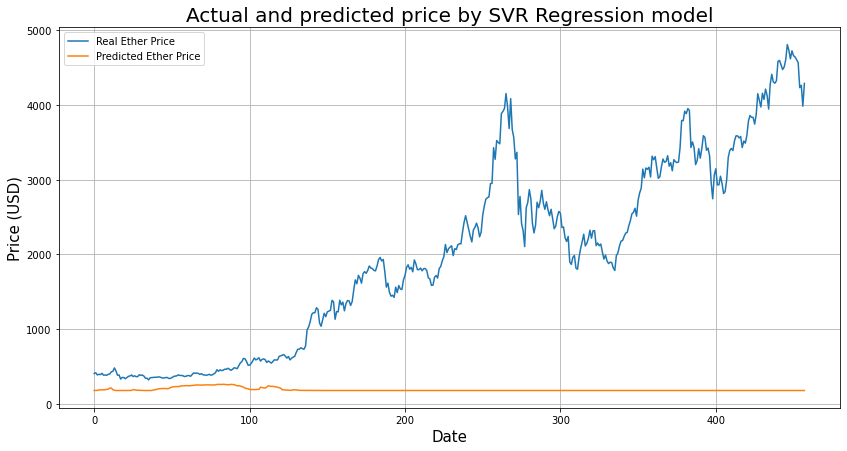

Pipeline(steps=[('scaling', StandardScaler()), ('classifier', SVR())])

In [15]:
ml_model(X_train, y_train, X_test, y_test, SVR(), 'Actual and predicted price by SVR Regression model')

#### 3.5 Ridge Regression

Evaluation metrics: 
R2 Score:  0.9784032312666304
Mean Absolute Error:  125.2145346164187
Mean Squared Error:  34676.57904053261
Mean Absolute Percentage Error (MDAPE): 6.86 %



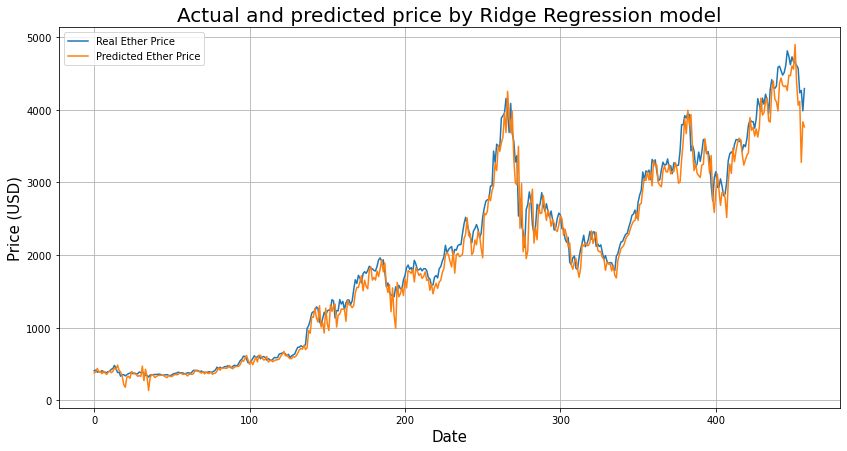

In [16]:
ridge_model = ml_model(X_train, y_train, X_test, y_test, Ridge(), 'Actual and predicted price by Ridge Regression model')

In [17]:
# Save the model to disk
filename = 'models/ridge_model.sav'
pickle.dump(ridge_model, open(filename, 'wb'))

#### 3.6 Lasso Regression

Evaluation metrics: 
R2 Score:  0.979042282004647
Mean Absolute Error:  127.02620420577348
Mean Squared Error:  33650.49529155473
Mean Absolute Percentage Error (MDAPE): 6.39 %



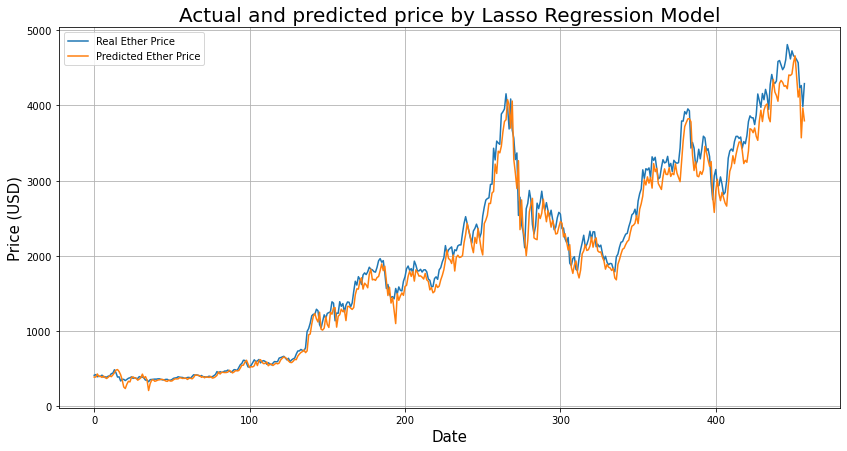

In [18]:
lasso_model = ml_model(X_train, y_train, X_test, y_test, Lasso(alpha=0.1), 'Actual and predicted price by Lasso Regression Model')

In [19]:
# Save the model to disk
filename = 'models/lasso_model.sav'
pickle.dump(lasso_model, open(filename, 'wb'))

#### 3.7 ElasticNet Regression

ElasticNet is a popular type of regularized linear regression that combines two popular penalties, specifically the L1 and L2 penalty functions.

Evaluation metrics: 
R2 Score:  0.9663060766886322
Mean Absolute Error:  158.77036844276196
Mean Squared Error:  54100.22255259814
Mean Absolute Percentage Error (MDAPE): 7.85 %



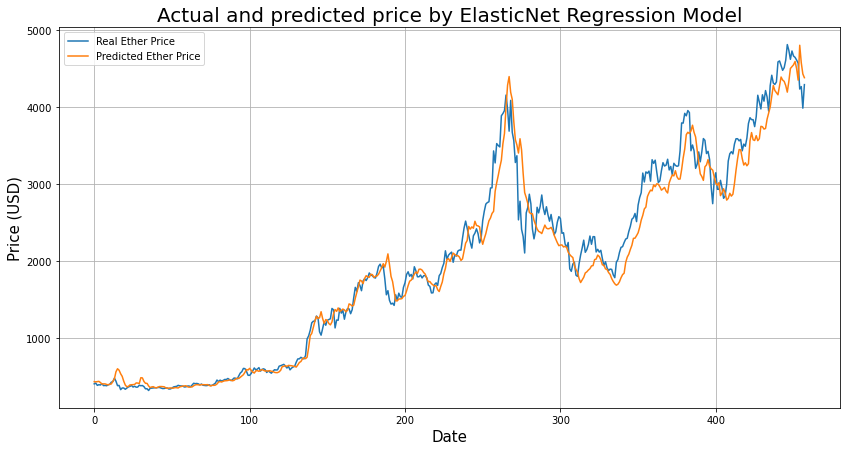

In [20]:
elasticnet_model = ml_model(X_train, y_train, X_test, y_test, ElasticNet(), 'Actual and predicted price by ElasticNet Regression Model')

In [21]:
# Save the model to disk
filename = 'models/elasticnet_model.sav'
pickle.dump(elasticnet_model, open(filename, 'wb'))

#### 5. Conclusion 
Best machine learning models in predicting the Ethereum price:
- Linear Regression with the r2 score is 0.95
- Ridge/Lasso/ElasticNet Regression with the r2 score is 0.97